# Modified GIC Estimation Using 3D Earth Conductivity

Authors: A. Kelbert, G. M. Lucas

Notebook/Code Author: Greg Lucas (greg.lucas@lasp.colorado.edu)


This is a notebook containing the methods for producing the hazard analysis and maps for the article. All data and code used here is open-source and freely available to download/use. I have tried to give descriptions where you'll need to get data and store it locally where appropriate.

There are several python package dependencies used below that you may need to install if you don't already have them. I have created a package called bezpy, which I make heavy use of here to manipulate all of the data. It can be found here, along with installation instructions: [bezpy](https://github.com/greglucas/bezpy)
There is also an SECS package that can be found here: [pysecs](https://github.com/greglucas/pysecs)

In [1]:
import os
import warnings
# Some libraries warn excessively
warnings.filterwarnings('ignore')
import glob
import time
import datetime
import copy

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# %matplotlib widget

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import shapely

plt.style.use(['seaborn-paper', 'tex.mplstyle'])

# Local Imports
import bezpy

## Add Turbo Colormap
[link](https://gist.github.com/mikhailov-work/ee72ba4191942acecc03fe6da94fc73f)

In [2]:
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
cmap_turbo = mpl.colors.ListedColormap(turbo_colormap_data)

In [3]:
# Choose colormap
afmhot_r = mpl.cm.get_cmap("afmhot_r")

cmap = afmhot_r
# Get the colormap colors
temp = cmap(np.arange(cmap.N))
# Set alpha
temp[:,-1] = np.linspace(0.25, 1, cmap.N)
afmhot_r_alpha = mpl.colors.ListedColormap(temp)

# Choose colormap
cmap = cmap_turbo

# Get the colormap colors
temp = cmap(np.arange(cmap.N))
# Set alpha
temp[:,-1] = np.linspace(0.25, 1, cmap.N)
turbo_alpha = mpl.colors.ListedColormap(temp)

# Choose colormap
seismic = mpl.cm.get_cmap("seismic")

# Get the colormap colors
cmap = seismic
temp = cmap(np.arange(cmap.N))
# Set alpha
# Go from 1 to 0.25 to 1 in a V shape
temp[:,-1] = np.abs(np.linspace(-0.75, 0.75, cmap.N)) + 0.25
seismic_alpha = mpl.colors.ListedColormap(temp)

## Map Setup
I am using [Cartopy](https://github.com/SciTools/cartopy) for the geographic plotting

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Data is lat/lon unless specifically different
proj_data = ccrs.PlateCarree()
projection = ccrs.LambertConformal(central_latitude=30, central_longitude=-96)

def add_features_to_ax(ax):
    land_alpha = 0.7
    scale = '10m'
    # 10m oceans are super slow...
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='slategrey', alpha=0.65, zorder=-1)
    ax.add_feature(cfeature.LAND.with_scale(scale), facecolor='k', alpha=land_alpha, zorder=0)
    ax.add_feature(cfeature.STATES.with_scale(scale), edgecolor='w', alpha=land_alpha, zorder=0)
    ax.add_feature(cfeature.LAKES.with_scale(scale), facecolor='slategrey', alpha=0.25, zorder=0)

## Geographic Processing Tools
These are routines for processing the data from geopandas dataframes that relate to the transmission line datasets

In [5]:
def get_intersections(df, lon_bounds, lat_bounds):
    spatial_index = df.sindex

    x0, x1 = lon_bounds
    y0, y1 = lat_bounds
    polygon = shapely.geometry.Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])

    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    return precise_matches

def get_intersection_polygon(df, polygon):
    spatial_index = df.sindex
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(polygon)]
    return precise_matches

def symlog(x):
    """Returns the symmetric log10 value, allowing for negatives"""
    return np.sign(x) * np.log10(np.abs(x))

def scale_vectors(x, y, scale=np.log10):
    """Scale vectors while preserving the angle.
    
    Parameters
    ==========
    x: Cartesian x coordinate(s)
    y: Cartesian y coordinate(s)
    
    scale: function to scale the magnitude by (Default: log10)"""
    mag = np.sqrt(x**2 + y**2)
    angle = np.arctan2(y, x)
    newx = scale(mag)*np.cos(angle)
    newy = scale(mag)*np.sin(angle)
    
    return (newx, newy)

US_lon_bounds = (-125, -66)
US_lat_bounds = (24, 50)

lon_bounds = US_lon_bounds
plot_lon_bounds = (lon_bounds[0] + 5, lon_bounds[1] - 5)
lat_bounds = US_lat_bounds

This is a generic boundary of the region where MT data is available.

In [6]:
US_shape = [[-126, 50], [-66, 50], [-66,23], [-84, 23], [-84, 30], [-88,36], [-98, 38], [-126, 38], [-126, 50]]
US_shape = shapely.geometry.Polygon(US_shape)

## Data files and directories

### Transmission Lines
Downloaded from the DHS Website:
[https://hifld-geoplatform.opendata.arcgis.com/](https://hifld-geoplatform.opendata.arcgis.com/)

There is a download for a shapefile called 'Electric_Power_Transmission_Lines.shp' on that website that you need.

### Impedance Tensors
Downloaded from the doi repository:
[doi:10.17611/DP/EMTF/USARRAY/TA](https://doi.org/10.17611/DP/EMTF/USARRAY/TA)

I downloaded all of the impedance tensors and have stored them in directories based upon the Survey's they were conducted during. You will just need to modify the code pointing to where these are downloaded later on if you have a different directory structure.

### Magnetic Field
Downloaded from the USGS Geomagnetism Program:
[https://geomag.usgs.gov](https://geomag.usgs.gov)

Downloaded from the NRCan Geomagnetism Program:
[http://www.geomag.nrcan.gc.ca/](http://www.geomag.nrcan.gc.ca/)

These are sometimes tedious to download for historic data. There are FTP servers for more recent data, which you can set up scripts for. I have downloaded all of the IAGA files, and converted them into binary netcdf files that can be read by xarray for much faster read/write times and smaller disk storage space. You will need to update the reader to point to your specific data files where appropriate.

In [7]:
fig_loc = "figs/"
data_loc = "data/"
trans_lines_file = data_loc + "Electric_Power_Transmission_Lines/Electric_Power_Transmission_Lines.shp"
MT_data_folder = data_loc + "MT_data/"
conductivity_folder = data_loc + "Conductivity/"
mag_field_folder = data_loc + "Bfields/"

## MT Sites
Read in all of the MT data and save the ones within the requested bounds

In [8]:
# Get all sub folders downloaded from the USArray website
xml_files = sorted(glob.glob(MT_data_folder + "MT_TF*/*.xml"))

MT_sites = []
site_xys = []

for fname in xml_files:
    
    site = bezpy.mt.read_xml(fname)
    # Only keep within our bounds
    if site.longitude < lon_bounds[0] or site.longitude > lon_bounds[1] or \
       site.latitude < lat_bounds[0] or site.latitude > lat_bounds[1]:
        continue
    
    if site.rating < 3:
        continue
        
    MT_sites.append(site)
    site_xys.append((site.latitude, site.longitude))
    
site_xys = np.array(site_xys)
print("There are {0} MT sites out of {1} total possible".format(len(MT_sites), len(xml_files)))

There are 1074 MT sites out of 1174 total possible


# Fernberg 1-D Conductivity

In [9]:
df_conductivity1d = gpd.read_file(conductivity_folder + "ConductivityRegions-polygon.shp")
# For some reason the Sl-1 is lowercase, change it to uppercase to match everything else
df_conductivity1d.loc[df_conductivity1d["Name"] == "Sl-1","Name"] = "SL-1"

# Load the 1d objects into the dataframe
df_conductivity1d["Site"] = df_conductivity1d.apply(lambda row: bezpy.mt.get_1d_site(row.Name), axis=1)

## Transmission Lines

In [10]:
df = gpd.read_file(trans_lines_file)
# Change all MultiLineString into LineString objects by grabbing the first line
# Will miss a few coordinates, but should be OK as an approximation
df.loc[df["geometry"].apply(lambda x: x.geometryType()) == "MultiLineString","geometry"] = \
    df.loc[df["geometry"].apply(lambda x: x.geometryType()) == "MultiLineString","geometry"].apply(lambda x: x[0])

# Get rid of erroneous 1MV and low power line voltages
df = df[(df["VOLTAGE"] >= 100)]

# Limit it to where EarthScope data is found
df = get_intersection_polygon(df, US_shape)

# Print out the size of the dataframe so far
print("Number of transmission lines: {0}".format(len(df)))

Number of transmission lines: 17853


Creating `bezpy` transmission line objects that have some additional capabilities like integration with them.

In [11]:
df["obj"] = df.apply(bezpy.tl.TransmissionLine, axis=1)
df["length"] = df.obj.apply(lambda x: x.length)

## Creating artificial straight lines

In [12]:
def latlon_from_distance(lat1, lon1, distance, angle):
    """
    Calculate a new point in latitude and longitude a given distance (km)
    and angle (deg, Counter clockwise from North) away from the input point (lat1, lon1).
    """
    lat1R, lon1R = np.deg2rad(lat1), np.deg2rad(lon1)
    distanceR = distance / 6371 # Radius of earth in (km)
    angleR = np.deg2rad(angle)
    lat2R = np.arcsin(np.sin(lat1R)*np.cos(distanceR) +
                      np.cos(lat1R)*np.sin(distanceR)*np.cos(angleR))
    if np.cos(lat2R) == 0:
        lon2R = lon1R
    else:
        lon2R = (lon1R - np.arcsin(np.sin(angleR)*np.sin(distanceR)/np.cos(lat2R)) + np.pi) % (2*np.pi)
        lon2R -= np.pi
    return (np.rad2deg(lat2R), np.rad2deg(lon2R))

In [13]:
transmission_line_lengths = [100, 200, 500, 1000]
center_point = (-80, 36)
angle_parallel = 50-90 # Angle from North
angle_perpendicular = angle_parallel + 90
delta = 1 # a point every 1 km
list_of_lines = []

def calc_point(distance, angle):
    return latlon_from_distance(center_point[1], center_point[0], distance, angle)

for line_length in transmission_line_lengths:
    npoints = int(line_length / delta) + 1

    # Parallel to the coast (B's)
    points = [calc_point(i*delta, angle_parallel)[::-1] for i in range(npoints)]
    line = shapely.geometry.LineString(points)
    list_of_lines.append(line)
    
    # Perpendicular (A's)
    points = [calc_point(i*delta, angle_perpendicular)[::-1] for i in range(npoints)]
    line = shapely.geometry.LineString(points)
    list_of_lines.append(line)
    
straight_lines = gpd.GeoDataFrame(geometry=list_of_lines)

straight_lines["name"] = ['B1', 'A1', 'B2', 'A2', 'B3', 'A3', 'B4', 'A4']
straight_lines["obj"] = straight_lines.apply(bezpy.tl.TransmissionLine, axis=1)
straight_lines["length"] = straight_lines.obj.apply(lambda x: x.length)
resistivity = 0.01 # Ohm/km
# (Ohm) = km * Ohm/km
# Grounding resistance assume 1 Ohm on each end, so add 2
straight_lines["resistance"] = straight_lines["length"]*resistivity + 2

straight_lines

geometry name  \
0  LINESTRING (-80.00000 36.00000, -79.99285 36.0...   B1   
1  LINESTRING (-80.00000 36.00000, -80.00852 36.0...   A1   
2  LINESTRING (-80.00000 36.00000, -79.99285 36.0...   B2   
3  LINESTRING (-80.00000 36.00000, -80.00852 36.0...   A2   
4  LINESTRING (-80.00000 36.00000, -79.99285 36.0...   B3   
5  LINESTRING (-80.00000 36.00000, -80.00852 36.0...   A3   
6  LINESTRING (-80.00000 36.00000, -79.99285 36.0...   B4   
7  LINESTRING (-80.00000 36.00000, -80.00852 36.0...   A4   

                                                 obj  length  resistance  
0  <bezpy.tl.transmissionline.TransmissionLine ob...   100.0         3.0  
1  <bezpy.tl.transmissionline.TransmissionLine ob...   100.0         3.0  
2  <bezpy.tl.transmissionline.TransmissionLine ob...   200.0         4.0  
3  <bezpy.tl.transmissionline.TransmissionLine ob...   200.0         4.0  
4  <bezpy.tl.transmissionline.TransmissionLine ob...   500.0         7.0  
5  <bezpy.tl.transmissionline.TransmissionLine ob...   500.0         7.0  
6  <bezpy.tl.transmissionline.TransmissionLine ob...  1000.0        12.0  
7  <bezpy.tl.transmissionline.TransmissionLine ob...  1000.0        12.0

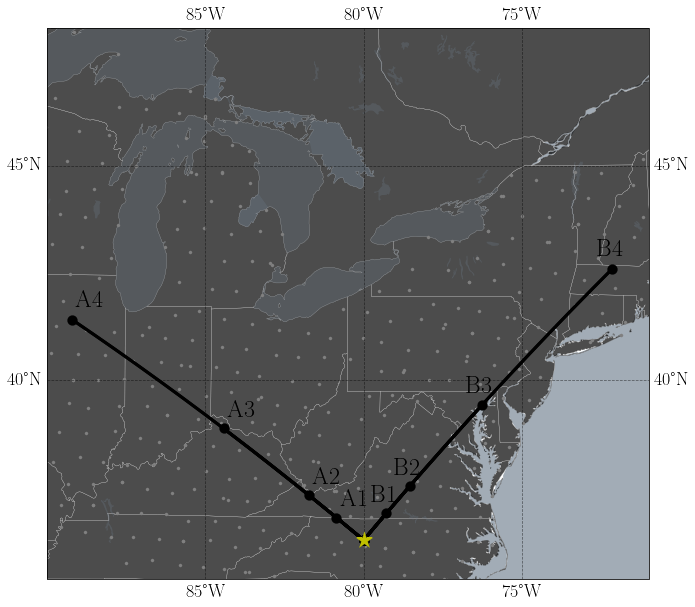

In [14]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Mercator()))

small_bounds = [-90, -71, 35, 48]
ax.set_extent(small_bounds, proj_data)
add_features_to_ax(ax)
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k',
                  alpha=0.5, linestyle='--', draw_labels=True, auto_inline=False,
                  xlocs=range(-90, -70, 5), ylocs=range(35, 50, 5))
gl.top_labels = True
gl.left_labels = True
gl.right_labels = True
gl.xlines = True
gl.ylines = True
gl.rotate_labels = False

# # Add gridlines and labels for the just the top to avoid spilling onto the sides.
# gl2 = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k',
#                   alpha=0.5, linestyle='--', draw_labels=False, auto_inline=False,
#                   xlocs=[-120, -70])
# gl2.top_labels = True

ax.scatter(site_xys[:,1], site_xys[:,0], s=10, c='gray', transform=proj_data, zorder=1)

for i, linestring in enumerate(straight_lines['geometry'][::-1]):
    xy = np.array(linestring)
    ax.plot(xy[::-1, 0], xy[::-1, 1], transform=proj_data, lw=3, c='k')
    ax.plot(xy[:, 0], xy[:, 1], transform=proj_data, lw=3, c='k')
    xloc = np.min(xy[:, 0]) if np.min(xy[:, 0]) < center_point[0] else np.max(xy[:, 0])-.6
    
    number_string = r'' + straight_lines.iloc[-1 - i]['name']
    ax.text(xloc + .1, np.max(xy[:, 1]) + .3, number_string, color='k',
            fontsize=24, zorder=10, transform=proj_data)
    ax.scatter(xy[0, 0], xy[0, 1], c='k', s=100, transform=proj_data)
    ax.scatter(xy[-1, 0], xy[-1, 1], c='k', s=100, transform=proj_data)
    
ax.scatter(center_point[0], center_point[1], marker='*', s=300, c='y', zorder=5, transform=proj_data)

fig.savefig(fig_loc + 'Line_GIC_map.png', bbox_inches='tight', dpi=200)

## Setting weights for transmission line integration
Sets weights from MT sites to transmission lines with a Delaunay triangular interpolation. This can take several minutes

In [15]:
t1 = time.time()
#df.obj.apply(lambda x: x.set_nearest_sites(site_xys))
df.obj.apply(lambda x: x.set_delaunay_weights(site_xys))
straight_lines.obj.apply(lambda x: x.set_delaunay_weights(site_xys))
print("Done filling interpolation weights: {0} s".format(time.time()-t1))

Done filling interpolation weights: 159.64244890213013 s


Remove lines with bad integration paths (outside of triangulation)

In [16]:
E_test = np.ones((1, len(site_xys), 2))

arr_delaunay = np.zeros(shape=(1, len(df)))
for i, tLine in enumerate(df.obj):
    arr_delaunay[:,i] = tLine.calc_voltages(E_test, how='delaunay')

df = df[~np.isnan(arr_delaunay[0, :])]

## Fill 1D Fernberg weights too

In [17]:
t1 = time.time()
df.obj.apply(lambda x: x.set_1d_regions(df_conductivity1d['geometry']))
straight_lines.obj.apply(lambda x: x.set_1d_regions(df_conductivity1d['geometry']))
print("Done filling interpolation weights: {0} s".format(time.time()-t1))

Done filling interpolation weights: 95.12010288238525 s


## Various methods to create 1D tensors from a 3D version

In [18]:
def best1D(Z3D):
    """
    This function takes a complex tensor (Z) with shape (nfreq, 4)
    and returns the best 1D approximation of that tensor.
    Z1 = (Zxy - Zyx)/2
    """
    Z1D = np.zeros(Z3D.shape, dtype=np.complex)
    average1D = (Z3D[:, 1] - Z3D[:, 2])/2.
    Z1D[:, 1] = average1D
    Z1D[:, 2] = -average1D
    return Z1D

def best1D_ssq(Z3D):
    """
    This function takes a complex tensor (Z) with shape (nfreq, 4)
    and returns the best 1D approximation of that tensor from
    equation 16 of Rung-Arunwan et al. 2016.
    Z1 = sqrt((Zxx^2 + Zxy^2 + Zyx^2 + Zyy^2)/2)
    """
    Z1D = np.zeros(Z3D.shape, dtype=np.complex)
    average1D = np.sqrt(np.sum(Z3D**2, axis=1)/2.)
    Z1D[:, 1] = average1D
    Z1D[:, 2] = -average1D
    return Z1D

def calc_ZXZY(Z):
    """
    This function takes a complex tensor (Z) with shape (nfreq, 4)
    and returns the ZX and ZY components ZX of shape (nfreq, 2) and
    ZY of shape (nfreq, 2)
    """
    return (Z[:, (0, 2)], Z[:, (1, 3)])

ZX / ZY are the components of Z that go into integration calculations for tauX and tauY. Basically just making book-keeping easier.

In [19]:
calc_type = ['3D', '1D', '1Dssq', '1Dfernberg']

In [20]:
nsites = len(site_xys)
freqs3 = 1./np.array([20, 200, 2000])
N3 = len(freqs3)

# X and Y
Z = {name: (np.zeros((N3, nsites, 2), dtype=np.complex),
            np.zeros((N3, nsites, 2), dtype=np.complex))
     for name in calc_type[:3]}


# MT Sites
for i, site in enumerate(MT_sites):
    siteZ = site.calcZ(freqs=freqs3).T
    
    Z['3D'][0][:, i, :], Z['3D'][1][:, i, :] = calc_ZXZY(siteZ)
    Z['1D'][0][:, i, :], Z['1D'][1][:, i, :] = calc_ZXZY(best1D(siteZ))
    Z['1Dssq'][0][:, i, :], Z['1Dssq'][1][:, i, :] = calc_ZXZY(best1D_ssq(siteZ))

# 1D Regions
Z['1Dfernberg'] = (np.zeros((N3, len(df_conductivity1d), 2), dtype=np.complex),
                   np.zeros((N3, len(df_conductivity1d), 2), dtype=np.complex))
for i, row in enumerate(df_conductivity1d.iterrows()):
    siteZ1d = row[1]['Site'].calcZ(freqs=freqs3).T
    Z['1Dfernberg'][0][:, i, :], Z['1Dfernberg'][1][:, i, :] = calc_ZXZY(siteZ1d)

## $\tau$ calculations

In [21]:
t0 = time.time()
n_trans_lines = len(df)

tau = {name: (np.zeros((N3, n_trans_lines), dtype=np.complex),
              np.zeros((N3, n_trans_lines), dtype=np.complex))
       for name in calc_type}

for i, tLine in enumerate(df.obj):
    if i % 1000 == 0:
        print(i, ':', time.time()-t0)
    
    for name in calc_type[:3]:
        tau[name][0][:, i] = tLine.calc_voltages(Z[name][0], how='delaunay')
        tau[name][1][:, i] = tLine.calc_voltages(Z[name][1], how='delaunay')
    
    
    # 1D Regions
    tau['1Dfernberg'][0][:, i] = tLine.calc_voltages(Z['1Dfernberg'][0], how='1d')
    tau['1Dfernberg'][1][:, i] = tLine.calc_voltages(Z['1Dfernberg'][1], how='1d')

0 : 0.0028672218322753906
1000 : 0.46687936782836914
2000 : 0.8788542747497559
3000 : 1.3219592571258545
4000 : 1.7763493061065674
5000 : 2.2351303100585938
6000 : 2.715090274810791
7000 : 3.158198118209839
8000 : 3.59175705909729
9000 : 4.01090931892395
10000 : 4.412535190582275
11000 : 4.850397348403931
12000 : 5.3171491622924805
13000 : 5.814011335372925
14000 : 6.331477403640747
15000 : 6.873603105545044
16000 : 7.401586294174194
17000 : 7.97568416595459


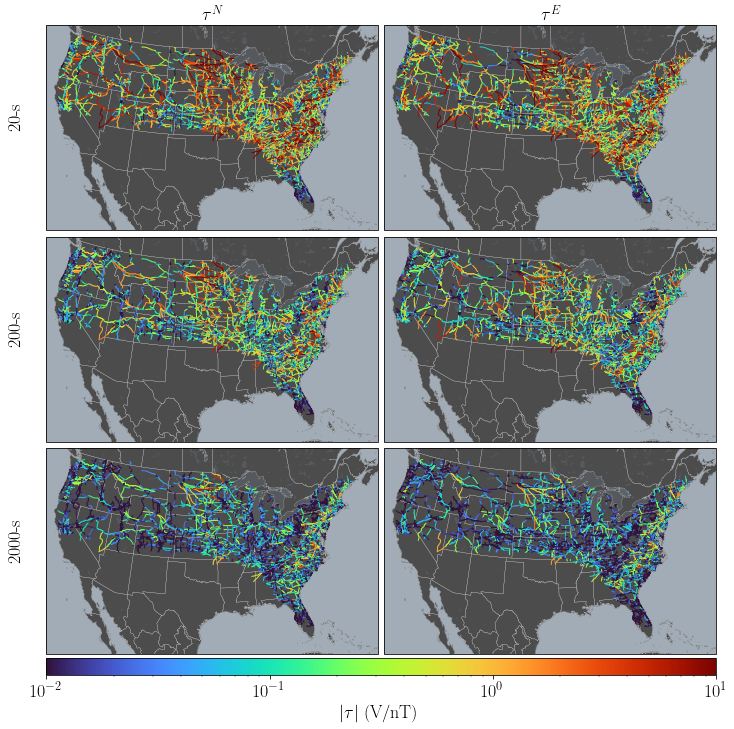

In [22]:
fig = plt.figure(figsize=(12, 12))

gs0 = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.08],
                        hspace=0.01, wspace=0.02)
ax_cbar = plt.subplot(gs0[-1,:]) # entire bottom

def draw_axes(ax, data):
    coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
    coll.set_array(data)

    vmin, vmax = 0.01, 1

#     cmap.set_bad(alpha=0.)
    # coll.set_cmap(turbo_alpha)
    coll.set_cmap(cmap_turbo)
    coll.set_clim(vmin, vmax)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    coll.set_norm(norm)
    coll.set_transform(proj_data)

    coll.set_linewidths(1) #calc_line_width(df["length"], log_scale=True))

    ax.add_collection(coll)

# 3 frequencies
labels = ['20-s', '200-s', '2000-s']
for ifreq in range(3):
    # x/y
    for j in range(2):
                    
        ax = plt.subplot(gs0[ifreq,j], projection=projection)

        ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
        add_features_to_ax(ax)
        
        if j == 0:
            ax.text(-0.07, 0.55, labels[ifreq], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, size=18)
            voltages = np.abs(tau['3D'][0][ifreq, :].copy())
        else:
            voltages = np.abs(tau['3D'][1][ifreq, :].copy())
            
        if ifreq == 0:
            if j == 0:
                ax.set_title(r'$\tau^N$')
            else:
                ax.set_title(r'$\tau^E$')
                
        draw_axes(ax, voltages)

#--------------------------------
# Colorbar
#--------------------------------
vmin, vmax = 0.01, 10
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap_turbo, norm=norm)
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, drawedges=False,
                             orientation='horizontal', ticklocation='bottom')
cbar.set_label(r"$|\tau|$ (V/nT)", size=18)
cbar.solids.set_rasterized(True) 

plt.savefig(fig_loc + 'tau_plot.png', bbox_inches='tight', dpi=200)

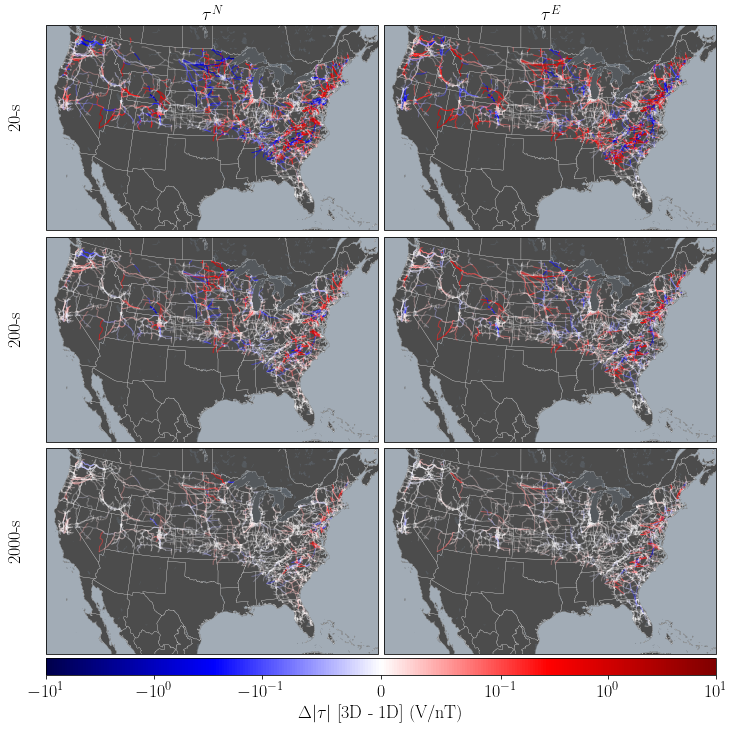

In [23]:
fig = plt.figure(figsize=(12, 12))

gs0 = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.08],
                        hspace=0.01, wspace=0.02)
ax_cbar = plt.subplot(gs0[-1,:]) # entire bottom

def draw_axes_diff(ax, data):
    coll = mpl.collections.LineCollection([np.array(linestring)[:, :2] for linestring in df['geometry']])
    data[np.isnan(data)] = 0.
    coll.set_array(data)

    vmin, vmax = -10, 10
    cmap = seismic_alpha
    cmap.set_bad(alpha=0.)
    coll.set_cmap(cmap)
    coll.set_clim(vmin, vmax)
    norm = mpl.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.1)
    coll.set_norm(norm)
    coll.set_transform(proj_data)

    coll.set_linewidths(1)

    ax.add_collection(coll)

# 3 frequencies
labels = ['20-s', '200-s', '2000-s']
for ifreq in range(3):
    # x/y
    for j in range(2):
                    
        ax = plt.subplot(gs0[ifreq,j], projection=projection)

        ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
        add_features_to_ax(ax)
        
        if j == 0:
            ax.text(-0.07, 0.55, labels[ifreq], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, size=18)
            voltages = np.abs(tau['3D'][0][ifreq, :].copy()) - np.abs(tau['1D'][0][ifreq, :].copy())
        else:
            voltages = np.abs(tau['3D'][1][ifreq, :].copy()) - np.abs(tau['1D'][1][ifreq, :].copy())
            
        if ifreq == 0:
            if j == 0:
                ax.set_title(r'$\tau^N$')
            else:
                ax.set_title(r'$\tau^E$')
                
        draw_axes_diff(ax, voltages)

#--------------------------------
# Colorbar
#--------------------------------
vmin, vmax = -10, 10
norm_diff = mpl.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.1)
sm = plt.cm.ScalarMappable(cmap=seismic, norm=norm_diff)
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, drawedges=False,
                             orientation='horizontal', ticklocation='bottom')
cbar.set_label(r"$\Delta |\tau|$ [3D - 1D] (V/nT)", size=18)
cbar.solids.set_rasterized(True) 

plt.savefig(fig_loc + 'tau_difference_1D.png', bbox_inches='tight', dpi=200)

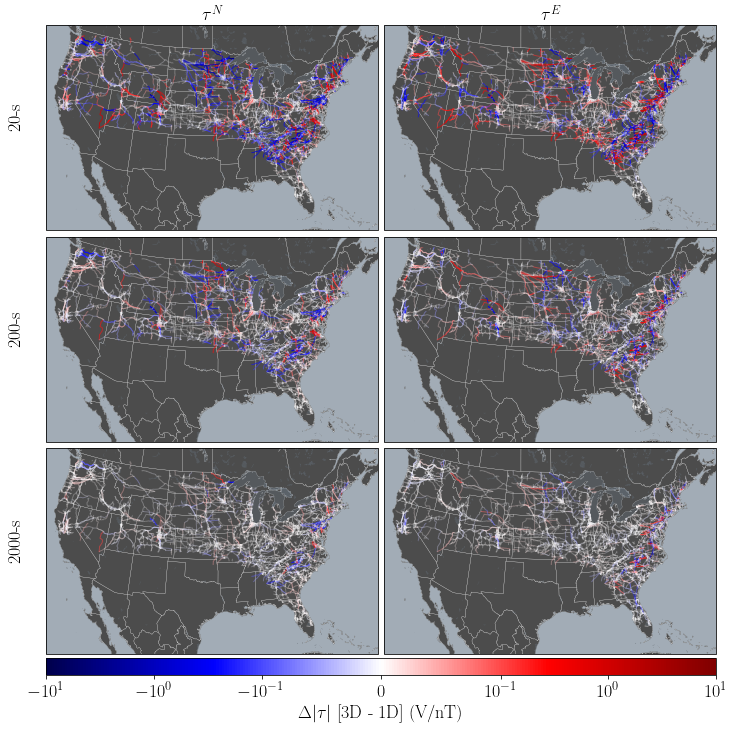

In [24]:
fig = plt.figure(figsize=(12, 12))

gs0 = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.08],
                        hspace=0.01, wspace=0.02)
ax_cbar = plt.subplot(gs0[-1,:]) # entire bottom

# 3 frequencies
labels = ['20-s', '200-s', '2000-s']
for ifreq in range(3):
    # x/y
    for j in range(2):
                    
        ax = plt.subplot(gs0[ifreq,j], projection=projection)

        ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
        add_features_to_ax(ax)
        
        if j == 0:
            ax.text(-0.07, 0.55, labels[ifreq], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, size=18)
            voltages = np.abs(tau['3D'][0][ifreq, :].copy()) - np.abs(tau['1Dssq'][0][ifreq, :].copy())
        else:
            voltages = np.abs(tau['3D'][1][ifreq, :].copy()) - np.abs(tau['1Dssq'][1][ifreq, :].copy())
            
        if ifreq == 0:
            if j == 0:
                ax.set_title(r'$\tau^N$')
            else:
                ax.set_title(r'$\tau^E$')
                
        draw_axes_diff(ax, voltages)

#--------------------------------
# Colorbar
#--------------------------------
vmin, vmax = -10, 10
norm_diff = mpl.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.1)
sm = plt.cm.ScalarMappable(cmap=seismic, norm=norm_diff)
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, drawedges=False,
                             orientation='horizontal', ticklocation='bottom')
cbar.set_label(r"$\Delta |\tau|$ [3D - 1D] (V/nT)", size=18)
cbar.solids.set_rasterized(True) 

plt.savefig(fig_loc + 'tau_difference_1Dssq.png', bbox_inches='tight', dpi=200)

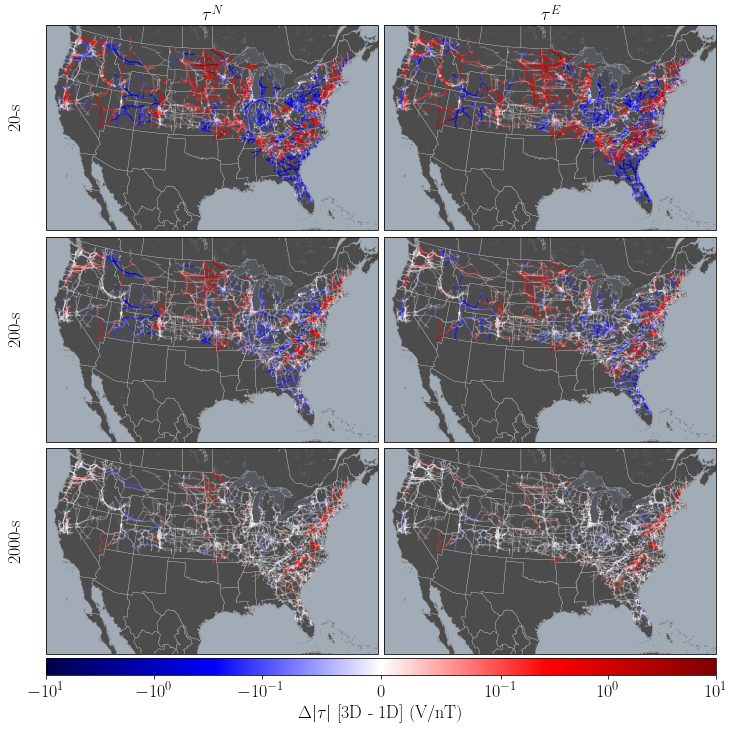

In [25]:
fig = plt.figure(figsize=(12, 12))

gs0 = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.08],
                        hspace=0.01, wspace=0.02)
ax_cbar = plt.subplot(gs0[-1,:]) # entire bottom

# 3 frequencies
labels = ['20-s', '200-s', '2000-s']
for ifreq in range(3):
    # x/y
    for j in range(2):
                    
        ax = plt.subplot(gs0[ifreq,j], projection=projection)

        ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
        add_features_to_ax(ax)
        
        if j == 0:
            ax.text(-0.07, 0.55, labels[ifreq], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, size=18)
            voltages = np.abs(tau['3D'][0][ifreq, :].copy()) - np.abs(tau['1Dfernberg'][0][ifreq, :].copy())
        else:
            voltages = np.abs(tau['3D'][1][ifreq, :].copy()) - np.abs(tau['1Dfernberg'][1][ifreq, :].copy())
            
        if ifreq == 0:
            if j == 0:
                ax.set_title(r'$\tau^N$')
            else:
                ax.set_title(r'$\tau^E$')
                
        draw_axes_diff(ax, voltages)

#--------------------------------
# Colorbar
#--------------------------------
vmin, vmax = -10, 10
norm_diff = mpl.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.1)
sm = plt.cm.ScalarMappable(cmap=seismic, norm=norm_diff)
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, drawedges=False,
                             orientation='horizontal', ticklocation='bottom')
cbar.set_label(r"$\Delta |\tau|$ [3D - 1D] (V/nT)", size=18)
cbar.solids.set_rasterized(True)

plt.savefig(fig_loc + 'tau_difference_1Dfernberg.png', bbox_inches='tight', dpi=200)

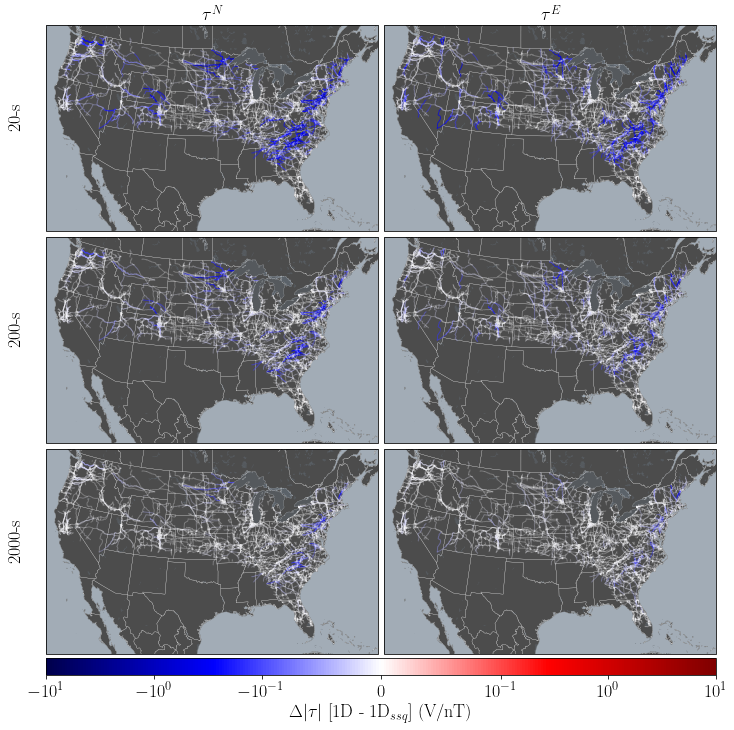

In [26]:
fig = plt.figure(figsize=(12, 12))

gs0 = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.08],
                        hspace=0.01, wspace=0.02)
ax_cbar = plt.subplot(gs0[-1,:]) # entire bottom

# 3 frequencies
labels = ['20-s', '200-s', '2000-s']
for ifreq in range(3):
    # x/y
    for j in range(2):
                    
        ax = plt.subplot(gs0[ifreq,j], projection=projection)

        ax.set_extent(plot_lon_bounds + lat_bounds, proj_data)
        add_features_to_ax(ax)
        
        if j == 0:
            ax.text(-0.07, 0.55, labels[ifreq], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, size=18)
            voltages = np.abs(tau['1D'][0][ifreq,:].copy()) - np.abs(tau['1Dssq'][0][ifreq,:].copy())
        else:
            voltages = np.abs(tau['1D'][1][ifreq,:].copy()) - np.abs(tau['1Dssq'][1][ifreq,:].copy())
            
        if ifreq == 0:
            if j == 0:
                ax.set_title(r'$\tau^N$')
            else:
                ax.set_title(r'$\tau^E$')
                
        draw_axes_diff(ax, voltages)

#--------------------------------
# Colorbar
#--------------------------------
vmin, vmax = -10, 10
norm_diff = mpl.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.1)
sm = plt.cm.ScalarMappable(cmap=seismic, norm=norm_diff)
cbar = mpl.colorbar.Colorbar(ax=ax_cbar, mappable=sm, drawedges=False,
                             orientation='horizontal', ticklocation='bottom')
cbar.set_label(r"$\Delta |\tau|$ [1D - 1D$_{ssq}$] (V/nT)", size=18)
cbar.solids.set_rasterized(True) 

plt.savefig(fig_loc + 'tau_difference_1D_1Dssq.png', bbox_inches='tight', dpi=200)

## Read in Magnetic Field Files

In [27]:
obs_files = glob.glob(mag_field_folder + "/*_dmin.nc")
obs_dict = {os.path.basename(x)[:3]: xr.open_dataset(x) for x in obs_files}

print("Number of observatories:", len(obs_dict))

Number of observatories: 24


In [28]:
obs_xy = []
for name in obs_dict:
    dataset = obs_dict[name]
    obs_xy.append((dataset.Latitude, dataset.Longitude))

obs_xy = np.squeeze(np.array(obs_xy))

## SECS Magnetic Field

In [29]:
from pysecs import SECS
R_earth = 6371e3

def calculate_SECS(B, obs_xy, pred_xy):
    """Calculate SECS output magnetic field
    
       B shape: (ntimes, nobs, 3 (xyz))
       
       obs_xy shape: (nobs, 2 (lat, lon))
       
       pred_xy shape: (npred, 2 (lat, lon))"""
    if obs_xy.shape[0] != B.shape[1]:
        raise ValueError("Number of observation points doesn't match B input")
        
    obs_lat_lon_r = np.zeros((len(obs_xy), 3))
    obs_lat_lon_r[:,0] = obs_xy[:,0]
    obs_lat_lon_r[:,1] = obs_xy[:,1]
    obs_lat_lon_r[:,2] = R_earth
    
    obs_std = np.ones((len(B), ) + obs_lat_lon_r.shape)
    # Don't include Z component in fits for now
    obs_std[:, :, 2] = np.inf
        
    # specify the SECS grid
    lat, lon, r = np.meshgrid(np.linspace(15,85,36), 
                              np.linspace(-175,-25,76),
                              R_earth+110000, indexing='ij')
    secs_lat_lon_r = np.hstack((lat.reshape(-1,1),
                                lon.reshape(-1,1),
                                r.reshape(-1,1)))
    
    secs = SECS(sec_df_loc=secs_lat_lon_r)

    secs.fit(obs_loc=obs_lat_lon_r, obs_B=B,
             obs_std=obs_std, epsilon=0.05)
    
    # Create prediction points
    pred_lat_lon_r = np.zeros((len(pred_xy), 3))
    pred_lat_lon_r[:,0] = pred_xy[:,0]
    pred_lat_lon_r[:,1] = pred_xy[:,1]
    pred_lat_lon_r[:,2] = R_earth
    
    B_pred = secs.predict_B(pred_lat_lon_r)
    
    return B_pred

In [30]:
# Only load data that we need.
obs_xy = []
B_obs = []

oneday = datetime.timedelta(days=1)
twoday = 2*oneday
halloween_storm = datetime.datetime(2003, 10, 30, 1)


event_time = halloween_storm
start_time, end_time = event_time-twoday, event_time+twoday
times = pd.date_range(start=start_time, end=end_time, freq='1Min')

B_frd = []

for name in obs_dict:
    dataset = obs_dict[name]
    data = dataset.loc[{'Time': slice(start_time, end_time)}]
    # No data here... skip ahead
    if len(data['Time']) == 0:
        continue
    data = data.interpolate_na('Time')
    #data = data.apply(lambda x: bezpy.mag.filter(x, sample_freq=1./60, highcut=1./60, lowcut=1./(10000)))
    data = np.array(data.loc[{'Time': slice(start_time, end_time)}].to_array().T)
    if np.any(np.isnan(data)):
        continue
    
    data = data - np.median(data, axis=0)
    obs_xy.append((dataset.Latitude, dataset.Longitude))
    B_obs.append(data)

obs_xy = np.squeeze(np.array(obs_xy))
B_obs = np.array(B_obs).swapaxes(0, 1)

## Creating new 'Sites' for 1D MT and transmission lines

In [31]:
nsites = len(site_xys)
freqs = np.logspace(-1, -4)
N = len(freqs)

# X and Y
Z = {name: (np.zeros((N, nsites, 2), dtype=np.complex),
            np.zeros((N, nsites, 2), dtype=np.complex))
     for name in calc_type[:3]}

site_dict = {name: [] for name in calc_type}

# MT Sites
for i, site in enumerate(MT_sites):
    siteZ = site.calcZ(freqs=freqs).T
    
    Z['3D'][0][:, i, :], Z['3D'][1][:, i, :] = calc_ZXZY(siteZ)
    Z['1D'][0][:, i, :], Z['1D'][1][:, i, :] = calc_ZXZY(best1D(siteZ))
    Z['1Dssq'][0][:, i, :], Z['1Dssq'][1][:, i, :] = calc_ZXZY(best1D_ssq(siteZ))
    
    for name in calc_type:
        site_dict[name].append(copy.deepcopy(site))
    
    site_dict['1D'][-1].Z = best1D(site.Z.T).T
    site_dict['1Dssq'][-1].Z = best1D_ssq(site.Z.T).T

# 1D Regions
Z['1Dfernberg'] = (np.zeros((N, len(df_conductivity1d), 2), dtype=np.complex),
                   np.zeros((N, len(df_conductivity1d), 2), dtype=np.complex))
for i, row in enumerate(df_conductivity1d.iterrows()):
    siteZ1d = row[1]['Site'].calcZ(freqs=freqs).T
    Z['1Dfernberg'][0][:, i, :], Z['1Dfernberg'][1][:, i, :] = calc_ZXZY(siteZ1d)

## $\tau$ calculations

In [32]:
t0 = time.time()
n_trans_lines = len(straight_lines)

tau = {name: (np.zeros((N, n_trans_lines), dtype=np.complex),
              np.zeros((N, n_trans_lines), dtype=np.complex))
       for name in calc_type}

tl_sites = {name: [] for name in calc_type}

for i, tLine in enumerate(straight_lines.obj):
    if i % 1000 == 0:
        print(i, ':', time.time()-t0)
        
    # Create and store new 'sites' for the transmission lines
    line_name = straight_lines.iloc[i]['name']
    line_site = bezpy.mt.Site3d(line_name)
    line_site.longitude = 0.
    line_site.latitude = 0.
    line_site.periods = 1./freqs
    line_site.Z = np.zeros((4, N), dtype=np.complex)
    
    for name in calc_type[:3]:
        tau[name][0][:, i] = tLine.calc_voltages(Z[name][0], how='delaunay')
        tau[name][1][:, i] = tLine.calc_voltages(Z[name][1], how='delaunay')
        newsite = copy.deepcopy(line_site)
        newsite.Z[1, :] = tau[name][1][:, i]
        newsite.Z[2, :] = tau[name][0][:, i]
        
        tl_sites[name].append(newsite)
    
    
    # 1D Regions
    tau['1Dfernberg'][0][:, i] = tLine.calc_voltages(Z['1Dfernberg'][0], how='1d')
    tau['1Dfernberg'][1][:, i] = tLine.calc_voltages(Z['1Dfernberg'][1], how='1d')
    line_site.Z[1, :] = tau['1Dfernberg'][1][:, i]
    line_site.Z[2, :] = tau['1Dfernberg'][0][:, i]
    tl_sites['1Dfernberg'].append(line_site)

0 : 0.0005891323089599609


In [33]:
t0 = time.time()
B_pred = calculate_SECS(B_obs, obs_xy, site_xys)
print("SECS calculation: ", time.time()-t0)

center_xy = np.array([[center_point[1], center_point[0]]])
B_pred_center = calculate_SECS(B_obs, obs_xy, center_xy)

ntimes = len(B_obs)

E = {}
V = {}
dfV = {}

E['1Dfernberg_nomag'] = np.zeros((ntimes, len(df_conductivity1d), 2))
V['1Dfernberg_nomag'] = np.zeros((ntimes, len(straight_lines)))

t0 = time.time()
for i, site in enumerate(df_conductivity1d['Site']):
    # Only one magnetic field location
    Ex, Ey = site.convolve_fft(B_pred_center[:, 0], B_pred_center[:, 1], dt=60)
    E['1Dfernberg_nomag'][:, i, 0] = Ex
    E['1Dfernberg_nomag'][:, i, 1] = Ey
print('fernberg E', (time.time()-t0))
    
t0 = time.time()
for i, tLine in enumerate(straight_lines.obj):
    V['1Dfernberg_nomag'][:, i] = tLine.calc_voltages(E['1Dfernberg_nomag'], how='1d')
print('fernberg V', (time.time()-t0))
dfV['1Dfernberg_nomag'] = pd.DataFrame(index=times, columns=straight_lines.index, data=V['1Dfernberg_nomag'])/straight_lines['resistance']

SECS calculation:  4.636091947555542
fernberg E 0.3179159164428711
fernberg V 0.8262989521026611


In [34]:
for name in calc_type[:3]:
    # Time the calculations
    t0 = time.time()
    E[name] = np.zeros((ntimes, nsites, 2))
    E[name + "_nomag"] = np.zeros((ntimes, nsites, 2))
    for i, site in enumerate(site_dict[name]):
        Ex, Ey = site.convolve_fft(B_pred[:, i, 0], B_pred[:, i, 1], dt=60)
        E[name][:, i, 0] = Ex
        E[name][:, i, 1] = Ey
        
        Ex, Ey = site.convolve_fft(B_pred_center[:, 0], B_pred_center[:, 1], dt=60)
        E[name + "_nomag"][:, i, 0] = Ex
        E[name + "_nomag"][:, i, 1] = Ey
    print(name, (time.time()-t0)/2)
    
t0 = time.time()
# Transmission line sites for Modified 3D calculation
V['modified'] = np.zeros((ntimes, len(straight_lines)))
for i, site in enumerate(tl_sites['3D']):
    Ex, Ey = site.convolve_fft(B_pred_center[:, 0], B_pred_center[:, 1], dt=60)
    V['modified'][:, i] = Ex + Ey
print('modified', (time.time()-t0))
dfV['modified'] = pd.DataFrame(index=times, columns=straight_lines.index, data=V['modified'])/straight_lines['resistance']

# All other voltage calculations
for name in calc_type[:3]:
    t0 = time.time()
    V[name] = np.zeros((ntimes, len(straight_lines)))
    V[name + '_nomag'] = np.zeros((ntimes, len(straight_lines)))
    for i, tLine in enumerate(straight_lines.obj):
        V[name][:, i] = tLine.calc_voltages(E[name], how='delaunay')
        V[name + '_nomag'][:, i] = tLine.calc_voltages(E[name + '_nomag'], how='delaunay')
        
    print(name, (time.time()-t0)/2)
    dfV[name] = pd.DataFrame(index=times, columns=straight_lines.index, data=V[name])/straight_lines['resistance']
    dfV[name + '_nomag'] = pd.DataFrame(index=times, columns=straight_lines.index, data=V[name + '_nomag'])/straight_lines['resistance']

3D 5.172521948814392
1D 5.177692532539368
1Dssq 4.961048483848572
modified 0.032106876373291016
3D 3.2537773847579956
1D 2.869449496269226
1Dssq 2.790197491645813


In [35]:
Bplots = [0, 2, 4, 6]
Aplots = [1, 3, 5, 7]

datemin, datemax = datetime.datetime(2003, 10, 29, 6), datetime.datetime(2003, 10, 30, 6)
datemin, datemax = datetime.datetime(2003, 10, 30, 12), datetime.datetime(2003, 10, 31, 12)

## Making 8 x 2 figures

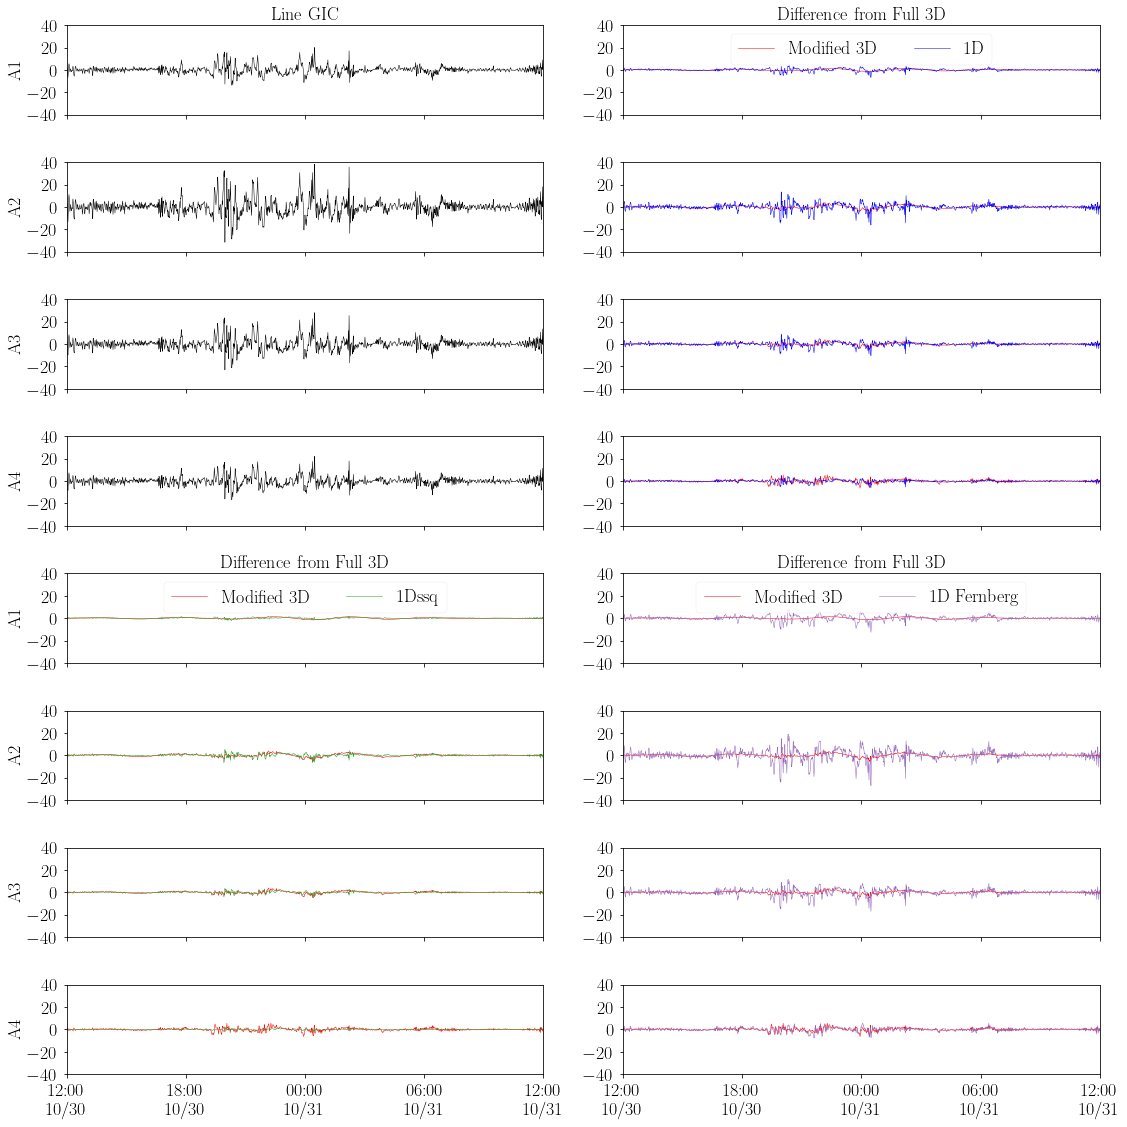

In [36]:
fig, axarr = plt.subplots(figsize=(16, 16), nrows=8, ncols=2, sharex=True)

for i, line_number in enumerate(Aplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1D'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('A{:d}'.format(i+1), color='k')
    ax1.set_ylim(-40, 40)
    ax1.set_yticks([-40, -20, 0, 20, 40])

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1D'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-40, 40)
    ax2.set_yticks([-40, -20, 0, 20, 40])


for i, line_number in enumerate(Aplots):
    ax1 = axarr[4 + i, 0]
    ax1.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax1.plot(dfV['1Dssq'][line_number] - dfV['3D'][line_number], c='tab:green', label='1Dssq', linewidth=0.5)
    ax1.set_ylabel('A{:d}'.format(i+1), color='k')
    ax1.set_ylim(-40, 40)
    ax1.set_yticks([-40, -20, 0, 20, 40])

    ax2 = axarr[4 + i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1Dfernberg_nomag'][line_number] - dfV['3D'][line_number], c='tab:purple', label='1D Fernberg', linewidth=0.5)
    ax2.set_ylim(-40, 40)
    ax2.set_yticks([-40, -20, 0, 20, 40])
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
axarr[4, 0].set_title('Difference from Full 3D')
axarr[4, 1].set_title('Difference from Full 3D')
# axarr[0, 0].legend(ncol=3, loc='upper center')
axarr[0, 1].legend(ncol=2, loc='upper center')
axarr[4, 0].legend(ncol=2, loc='upper center')
axarr[4, 1].legend(ncol=2, loc='upper center')

dates = pd.date_range(datemin, datemax, freq='6H')
ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_A_8x2.pdf')

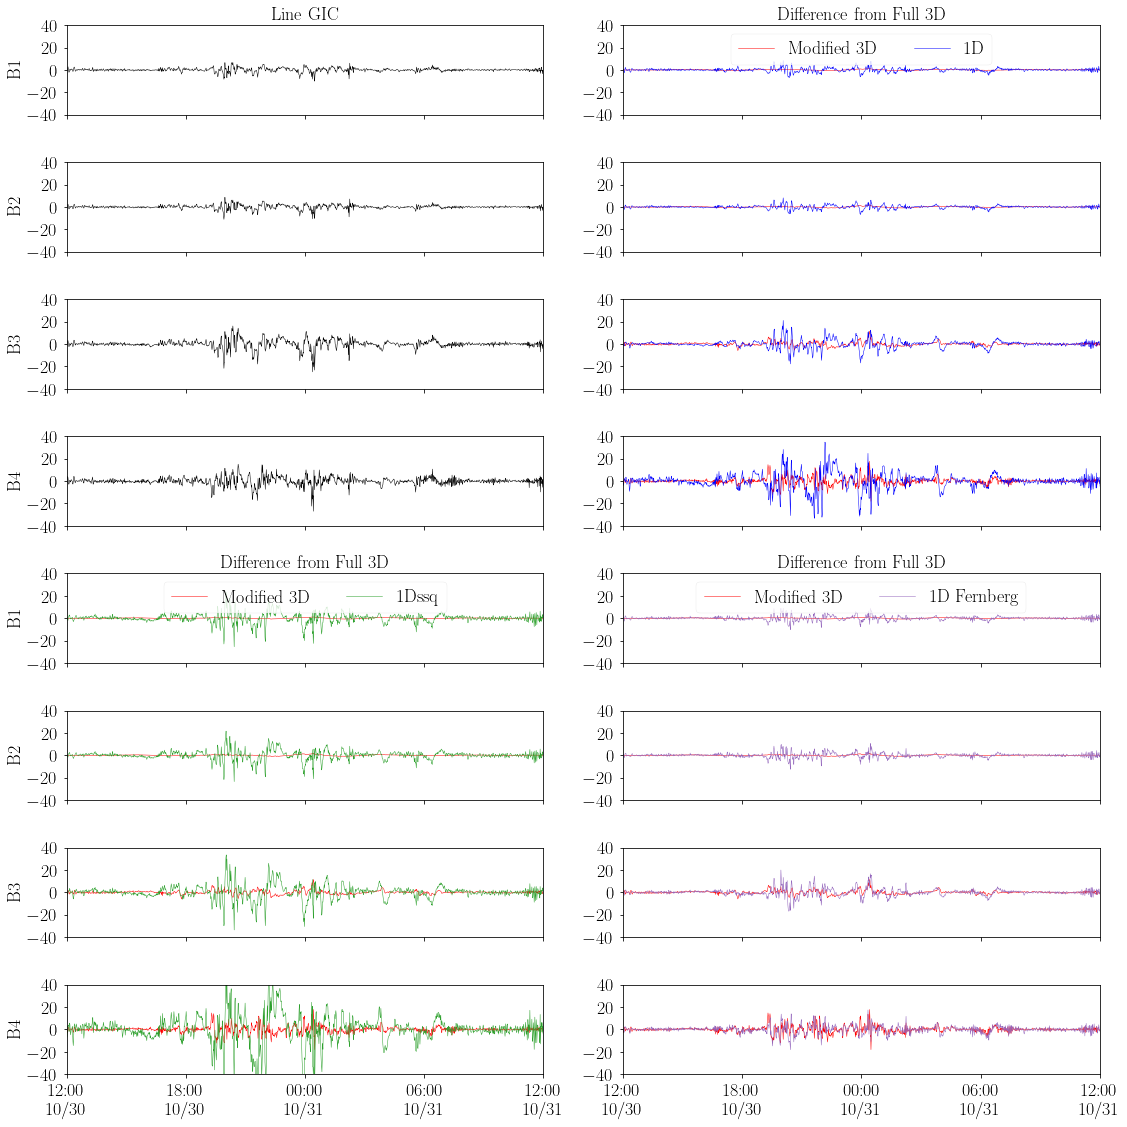

In [37]:
fig, axarr = plt.subplots(figsize=(16, 16), nrows=8, ncols=2, sharex=True)

for i, line_number in enumerate(Bplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1D'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('B{:d}'.format(i+1), color='k')
    ax1.set_ylim(-40, 40)
    ax1.set_yticks([-40, -20, 0, 20, 40])

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1D'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-40, 40)
    ax2.set_yticks([-40, -20, 0, 20, 40])


for i, line_number in enumerate(Bplots):
    ax1 = axarr[4 + i, 0]
    ax1.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax1.plot(dfV['1Dssq'][line_number] - dfV['3D'][line_number], c='tab:green', label='1Dssq', linewidth=0.5)
    ax1.set_ylabel('B{:d}'.format(i+1), color='k')
    ax1.set_ylim(-40, 40)
    ax1.set_yticks([-40, -20, 0, 20, 40])

    ax2 = axarr[4 + i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1Dfernberg_nomag'][line_number] - dfV['3D'][line_number], c='tab:purple', label='1D Fernberg', linewidth=0.5)
    ax2.set_ylim(-40, 40)
    ax2.set_yticks([-40, -20, 0, 20, 40])
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
axarr[4, 0].set_title('Difference from Full 3D')
axarr[4, 1].set_title('Difference from Full 3D')
axarr[0, 1].legend(ncol=2, loc='upper center')
axarr[4, 0].legend(ncol=2, loc='upper center')
axarr[4, 1].legend(ncol=2, loc='upper center')

dates = pd.date_range(datemin, datemax, freq='6H')
ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_B_8x2.pdf')

## Breaking the figures out

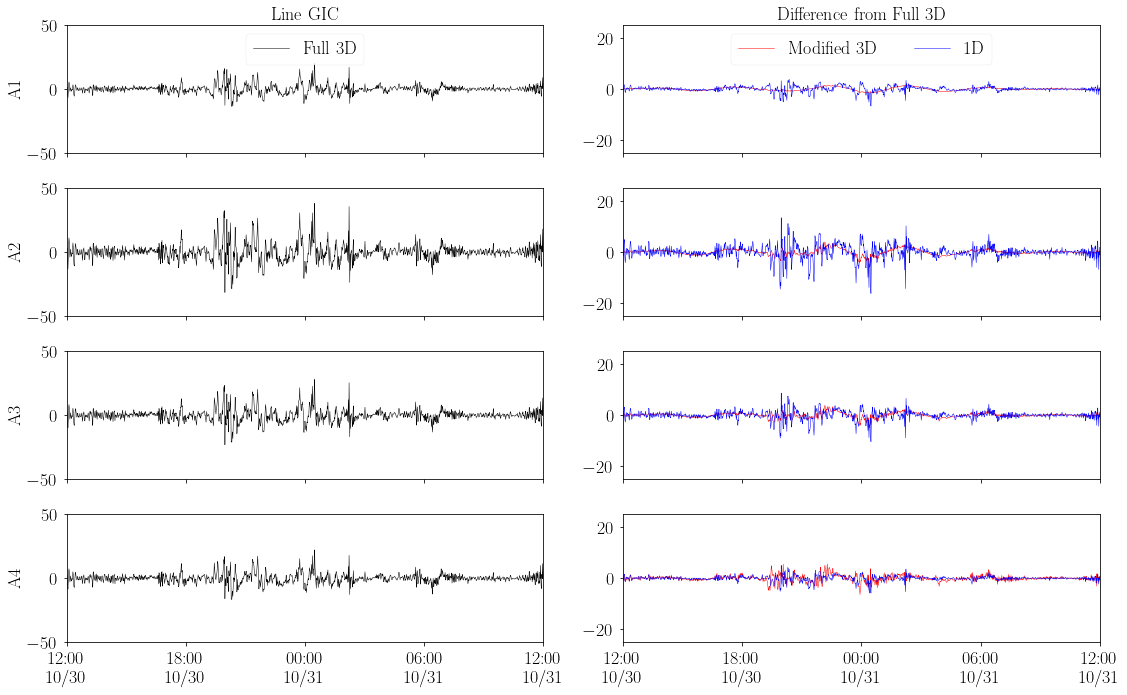

In [38]:
fig, axarr = plt.subplots(figsize=(16, 10), nrows=4, ncols=2, sharex=True)

for i, line_number in enumerate(Aplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1D'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('A{:d}'.format(i+1), color='k')
    ax1.set_ylim(-50, 50)

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1D'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-25, 25)
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
# axarr[0, 1].legend((line1, line2, line3), ('Full 3D', 'Modified 3D', 'Best 1D'), ncol=3,
#            bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.)
axarr[0, 0].legend(ncol=3, loc='upper center')
axarr[0, 1].legend(ncol=2, loc='upper center')

dates = pd.date_range(datemin, datemax, freq='6H')
ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_A.pdf')

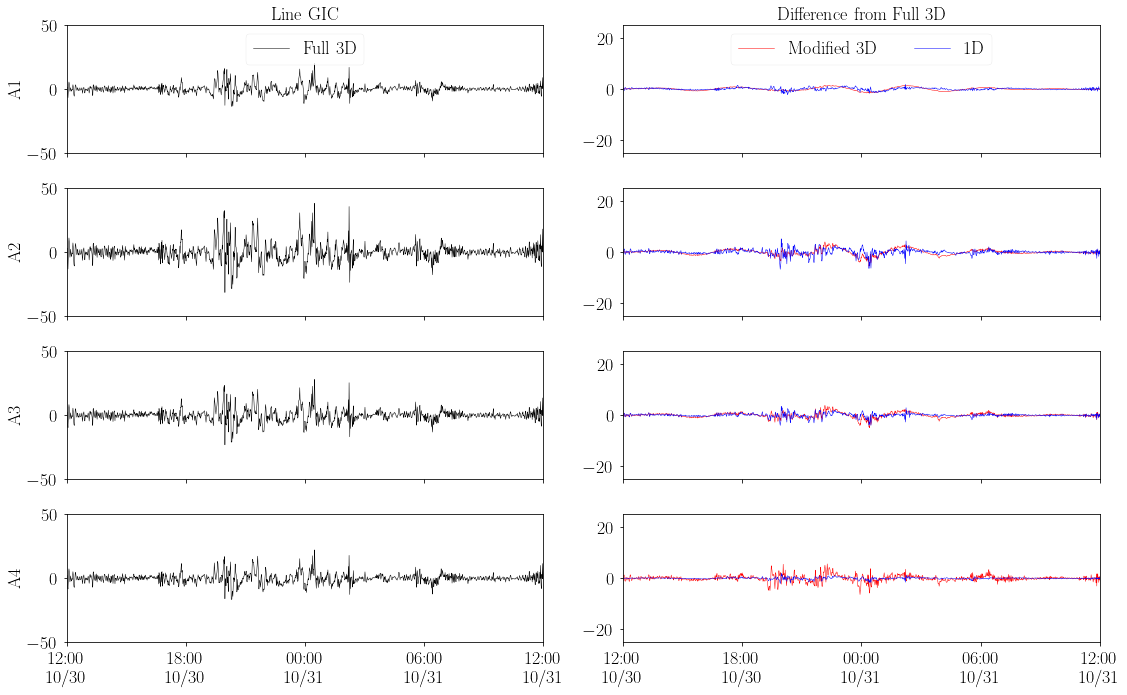

In [39]:
fig, axarr = plt.subplots(figsize=(16, 10), nrows=4, ncols=2, sharex=True)

for i, line_number in enumerate(Aplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1Dssq'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('A{:d}'.format(i+1), color='k')
    ax1.set_ylim(-50, 50)

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1Dssq'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-25, 25)
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
axarr[0, 0].legend(ncol=3, loc='upper center')
axarr[0, 1].legend(ncol=2, loc='upper center')

dates = pd.date_range(datemin, datemax, freq='6H')
ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_A_ssq.pdf')

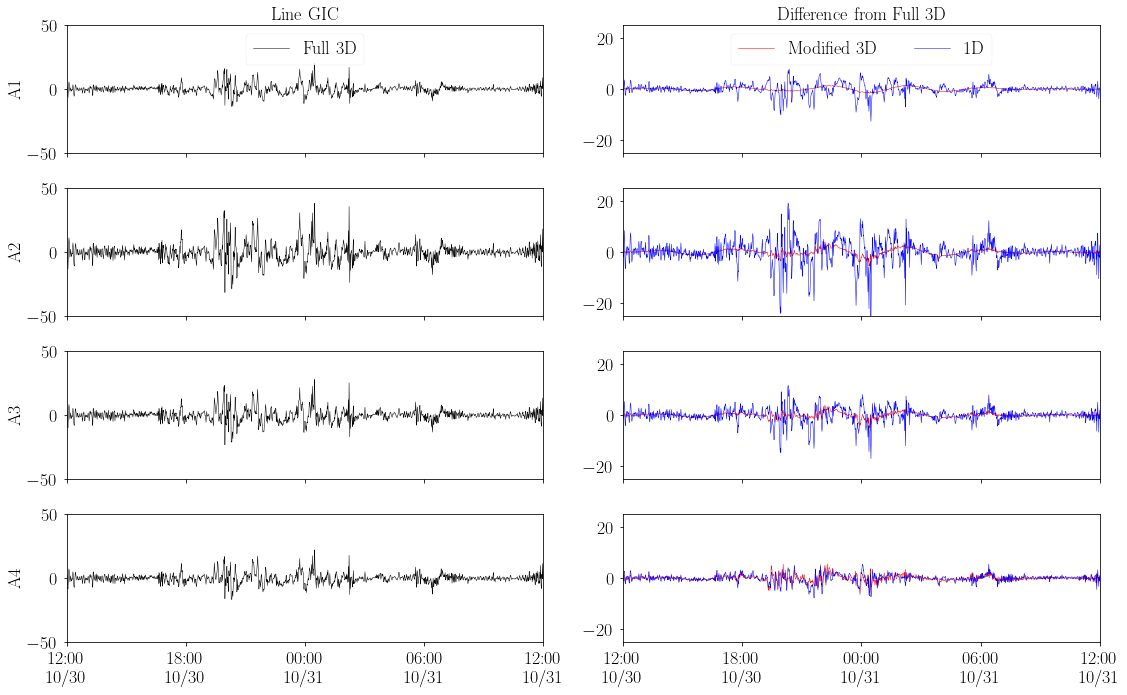

In [40]:
fig, axarr = plt.subplots(figsize=(16, 10), nrows=4, ncols=2, sharex=True)

for i, line_number in enumerate(Aplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1Dfernberg_nomag'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('A{:d}'.format(i+1), color='k')
    ax1.set_ylim(-50, 50)

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1Dfernberg_nomag'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-25, 25)
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
axarr[0, 0].legend(ncol=3, loc='upper center')
axarr[0, 1].legend(ncol=2, loc='upper center')

dates = pd.date_range(datemin, datemax, freq='6H')
ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_A_fernberg.pdf')

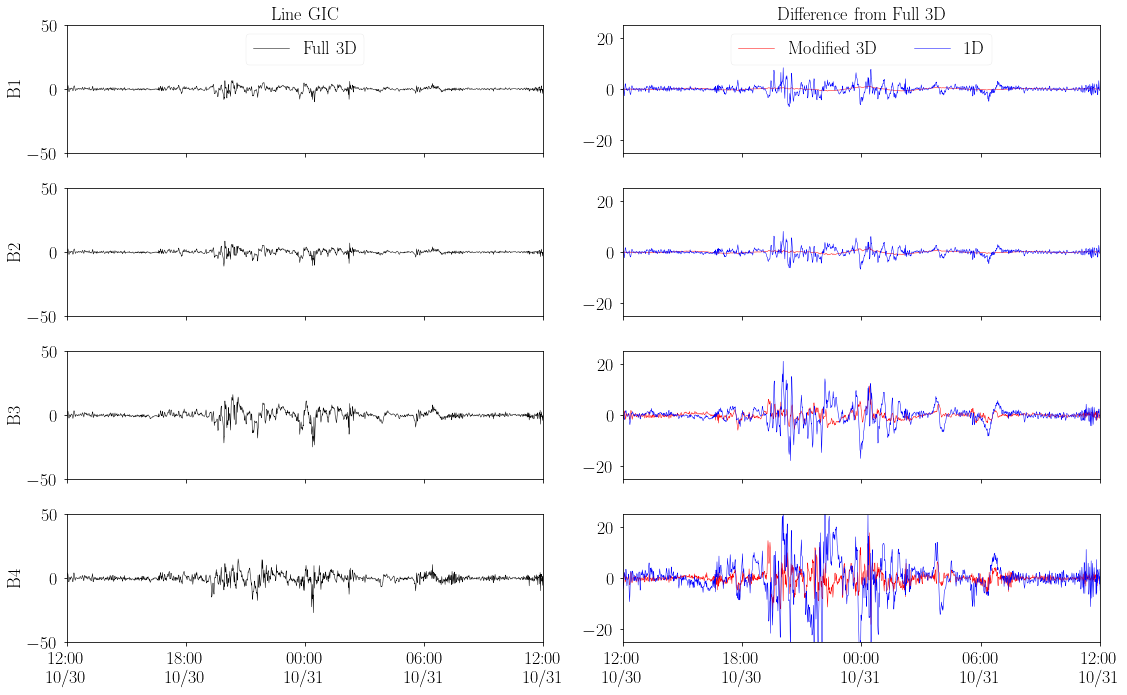

In [41]:
fig, axarr = plt.subplots(figsize=(16, 10), nrows=4, ncols=2, sharex=True)

for i, line_number in enumerate(Bplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1D'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('B{:d}'.format(i+1), color='k')
    ax1.set_ylim(-50, 50)

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1D'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-25, 25)
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
# axarr[0, 1].legend((line1, line2, line3), ('Full 3D', 'Modified 3D', 'Best 1D'), ncol=3,
#            bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.)
axarr[0, 0].legend(ncol=3, loc='upper center')
axarr[0, 1].legend(ncol=2, loc='upper center')

ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_B.pdf')

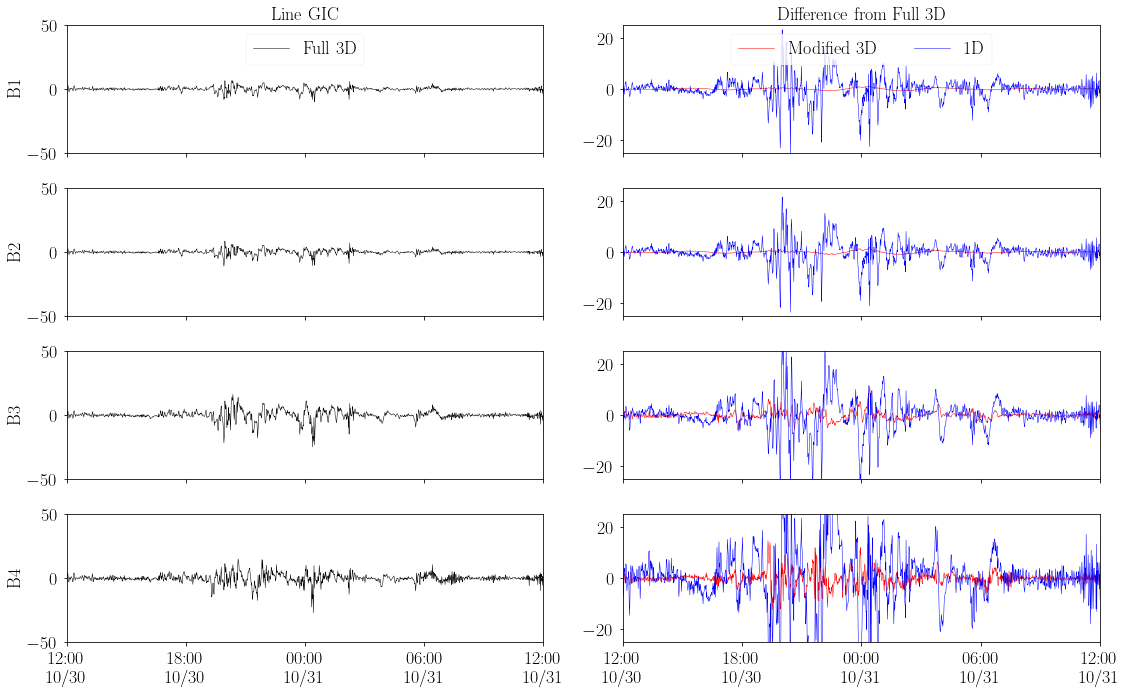

In [42]:
fig, axarr = plt.subplots(figsize=(16, 10), nrows=4, ncols=2, sharex=True)

for i, line_number in enumerate(Bplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1Dssq'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('B{:d}'.format(i+1), color='k')
    ax1.set_ylim(-50, 50)

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1Dssq'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-25, 25)
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
# axarr[0, 1].legend((line1, line2, line3), ('Full 3D', 'Modified 3D', 'Best 1D'), ncol=3,
#            bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.)
axarr[0, 0].legend(ncol=3, loc='upper center')
axarr[0, 1].legend(ncol=2, loc='upper center')

ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_B_ssq.pdf')

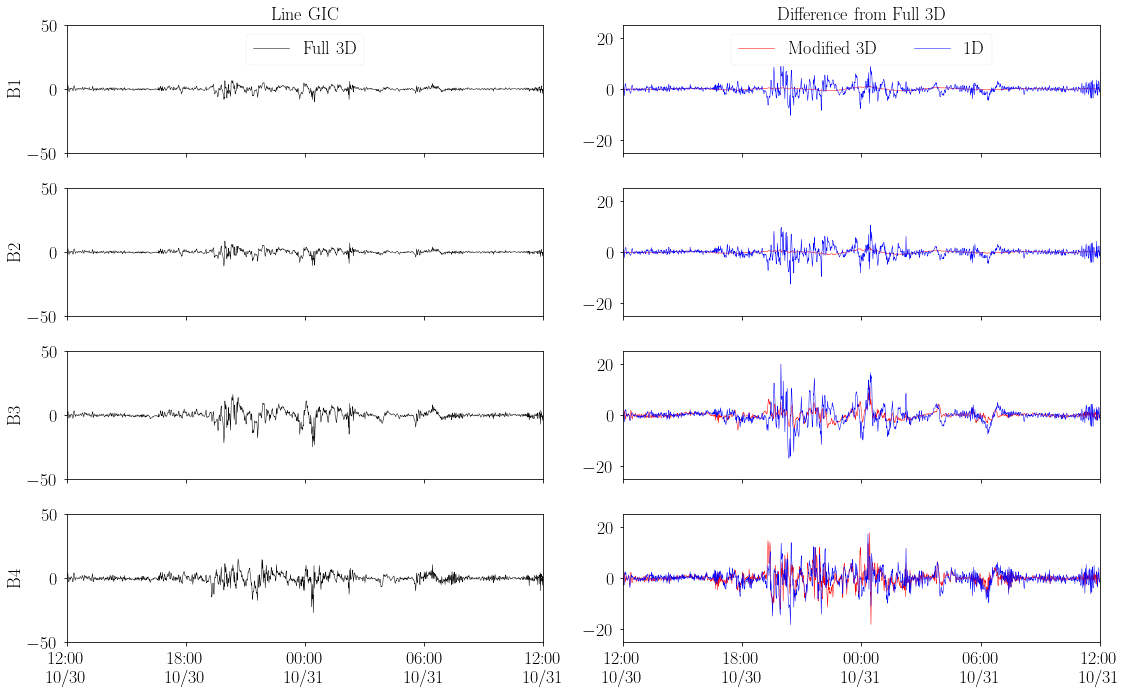

In [43]:
fig, axarr = plt.subplots(figsize=(16, 10), nrows=4, ncols=2, sharex=True)

for i, line_number in enumerate(Bplots):
    ax1 = axarr[i, 0]
    line1, = ax1.plot(dfV['3D'][line_number], c='k', label='Full 3D', linewidth=0.5, zorder=2.5)
#     line2, = ax1.plot(dfV['modified'][line_number], c='r', label='Modified 3D', linewidth=0.5)
#     line3, = ax1.plot(dfV['1Dfernberg_nomag'][line_number], c='b', label='1D', linewidth=0.5)
    ax1.set_ylabel('B{:d}'.format(i+1), color='k')
    ax1.set_ylim(-50, 50)

    ax2 = axarr[i, 1]
    ax2.plot(dfV['modified'][line_number] - dfV['3D'][line_number], c='r', label='Modified 3D', linewidth=0.5)
    ax2.plot(dfV['1Dfernberg_nomag'][line_number] - dfV['3D'][line_number], c='b', label='1D', linewidth=0.5)
    ax2.set_ylim(-25, 25)
    
axarr[0, 0].set_xlim(datemin, datemax)

axarr[0, 0].set_title('Line GIC')
axarr[0, 1].set_title('Difference from Full 3D')
# axarr[0, 1].legend((line1, line2, line3), ('Full 3D', 'Modified 3D', 'Best 1D'), ncol=3,
#            bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.)
axarr[0, 0].legend(ncol=3, loc='upper center')
axarr[0, 1].legend(ncol=2, loc='upper center')

ax = axarr[0, 0]
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in dates])

fig.savefig(fig_loc + 'Line_GIC_B_fernberg.pdf')

In [44]:
def calc_max_difference(df_input, line_number):
    return np.max(np.abs((df_input - dfV['3D'])[datemin:datemax][line_number]))

def calc_rms_difference(df_input, line_number):
    return np.sqrt(np.mean(((df_input - dfV['3D'])[datemin:datemax][line_number])**2))

def calc_max(df_input, line_number):
    return np.max(np.abs((df_input)[datemin:datemax][line_number]))

print("Max Differences from full 3D")
print("  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\\\")
for i, line_number in enumerate(Aplots):
    valmodified = calc_max_difference(dfV['modified'], line_number)
    val1D = calc_max_difference(dfV['1D'], line_number)
    val1Dssq = calc_max_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & A{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

for i, line_number in enumerate(Bplots):
    valmodified = calc_max_difference(dfV['modified'], line_number)
    val1D = calc_max_difference(dfV['1D'], line_number)
    val1Dssq = calc_max_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & B{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

print("")
print("")
print("RMS Differences from full 3D")
print("  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\\\")
for i, line_number in enumerate(Aplots):
    valmodified = calc_rms_difference(dfV['modified'], line_number)
    val1D = calc_rms_difference(dfV['1D'], line_number)
    val1Dssq = calc_rms_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_rms_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_rms_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_rms_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_rms_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & A{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

for i, line_number in enumerate(Bplots):
    valmodified = calc_rms_difference(dfV['modified'], line_number)
    val1D = calc_rms_difference(dfV['1D'], line_number)
    val1Dssq = calc_rms_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_rms_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_rms_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_rms_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_rms_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & B{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

print("")
print("")
print("Maximum GIC (A)")
print("  & Line & Full 3D & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\\\")
for i, line_number in enumerate(Aplots):
    val = calc_max(dfV['3D'], line_number)
    valmodified = calc_max(dfV['modified'], line_number)
    val1D = calc_max(dfV['1D'], line_number)
    val1Dssq = calc_max(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max(dfV['1Dfernberg_nomag'], line_number)
    print("  & A{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, val, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

for i, line_number in enumerate(Bplots):
    val = calc_max(dfV['3D'], line_number)
    valmodified = calc_max(dfV['modified'], line_number)
    val1D = calc_max(dfV['1D'], line_number)
    val1Dssq = calc_max(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max(dfV['1Dfernberg_nomag'], line_number)
    print("  & B{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, val, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

Max Differences from full 3D
  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\
  & A1 & 1.56 & 6.70 & 2.20 & 0.52 & 6.42 & 2.32 & 12.65 \\
  & A2 & 5.51 & 16.21 & 6.74 & 3.11 & 16.71 & 9.26 & 27.18 \\
  & A3 & 4.94 & 10.37 & 4.00 & 3.23 & 11.53 & 6.65 & 17.02 \\
  & A4 & 6.35 & 5.77 & 2.08 & 6.03 & 6.77 & 6.45 & 7.68 \\
  & B1 & 1.11 & 8.36 & 25.55 & 0.39 & 8.80 & 25.54 & 10.32 \\
  & B2 & 1.87 & 8.14 & 23.56 & 1.04 & 8.19 & 23.39 & 12.53 \\
  & B3 & 11.52 & 21.14 & 33.66 & 10.01 & 17.89 & 33.68 & 20.00 \\
  & B4 & 18.06 & 34.86 & 54.56 & 19.20 & 40.27 & 69.78 & 18.16 \\


RMS Differences from full 3D
  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\
  & A1 & 0.59 & 1.04 & 0.45 & 0.08 & 1.03 & 0.45 & 2.03 \\
  & A2 & 1.11 & 2.65 & 1.04 & 0.48 & 2.77 & 1.28 & 4.46 \\
  & A3 & 0.93 & 1.68 & 0.69 & 0.59 & 1.85 & 1.01 & 2.73 \\
  & A4 & 1.18 & 0.95 & 0.34 & 1.06 & 1.40 & 1.15 & 1.50 \\
  & B1 & 0.32 & 1.52 & 4.27

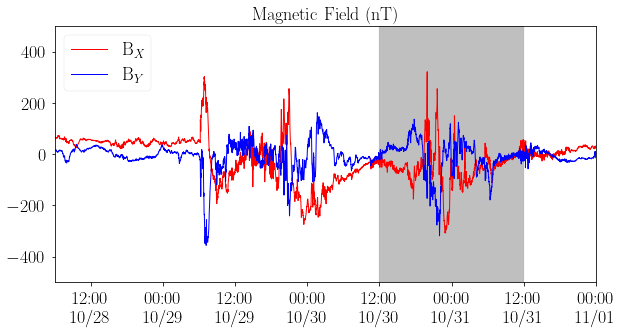

In [45]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(times, B_pred_center[:, 0], c='r', label=r'B$_{X}$')
ax.plot(times, B_pred_center[:, 1], c='b', label=r'B$_{Y}$')
ax.legend(ncol=1, loc='upper left', framealpha=1)
ax.set_title('Magnetic Field (nT)')
ax.set_ylim(-500, 500)
ax.set_xlim(datetime.datetime(2003, 10, 28, 6), datetime.datetime(2003, 11, 1, 0))
ax.axvspan(datemin, datemax, alpha=0.5, color='gray', zorder=-1)

bfield_dates = [datetime.datetime(2003, 10, 28, 12), datetime.datetime(2003, 10, 29, 0),
                datetime.datetime(2003, 10, 29, 12), datetime.datetime(2003, 10, 30, 0),
                datetime.datetime(2003, 10, 30, 12), datetime.datetime(2003, 10, 31, 0),
                datetime.datetime(2003, 10, 31, 12), datetime.datetime(2003, 11, 1, 0)]
ax.set_xticks(bfield_dates)
ax.set_xticklabels([date.strftime("%H:00\n%m/%d") for date in bfield_dates])

fig.savefig(fig_loc + 'Line_GIC_Bfield.pdf')

## No subsetting of time

In [46]:
def calc_max_difference(df_input, line_number):
    return np.max(np.abs((df_input - dfV['3D'])[line_number]))

def calc_rms_difference(df_input, line_number):
    return np.sqrt(np.mean(((df_input - dfV['3D'])[line_number])**2))

def calc_max(df_input, line_number):
    return np.max(np.abs((df_input)[line_number]))

print("Max Differences from full 3D")
print("  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\\\")
for i, line_number in enumerate(Aplots):
    valmodified = calc_max_difference(dfV['modified'], line_number)
    val1D = calc_max_difference(dfV['1D'], line_number)
    val1Dssq = calc_max_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & A{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

for i, line_number in enumerate(Bplots):
    valmodified = calc_max_difference(dfV['modified'], line_number)
    val1D = calc_max_difference(dfV['1D'], line_number)
    val1Dssq = calc_max_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & B{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

print("")
print("")
print("RMS Differences from full 3D")
print("  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\\\")
for i, line_number in enumerate(Aplots):
    valmodified = calc_rms_difference(dfV['modified'], line_number)
    val1D = calc_rms_difference(dfV['1D'], line_number)
    val1Dssq = calc_rms_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_rms_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_rms_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_rms_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_rms_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & A{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

for i, line_number in enumerate(Bplots):
    valmodified = calc_rms_difference(dfV['modified'], line_number)
    val1D = calc_rms_difference(dfV['1D'], line_number)
    val1Dssq = calc_rms_difference(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_rms_difference(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_rms_difference(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_rms_difference(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_rms_difference(dfV['1Dfernberg_nomag'], line_number)
    print("  & B{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

print("")
print("")
print("Maximum GIC (A)")
print("  & Line & Full 3D & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\\\")
for i, line_number in enumerate(Aplots):
    val = calc_max(dfV['3D'], line_number)
    valmodified = calc_max(dfV['modified'], line_number)
    val1D = calc_max(dfV['1D'], line_number)
    val1Dssq = calc_max(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max(dfV['1Dfernberg_nomag'], line_number)
    print("  & A{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, val, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

for i, line_number in enumerate(Bplots):
    val = calc_max(dfV['3D'], line_number)
    valmodified = calc_max(dfV['modified'], line_number)
    val1D = calc_max(dfV['1D'], line_number)
    val1Dssq = calc_max(dfV['1Dssq'], line_number)
    
    val3D_nomag = calc_max(dfV['3D_nomag'], line_number)
    val1D_nomag = calc_max(dfV['1D_nomag'], line_number)
    val1Dssq_nomag = calc_max(dfV['1Dssq_nomag'], line_number)
    val1Dfernberg_nomag = calc_max(dfV['1Dfernberg_nomag'], line_number)
    print("  & B{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
          i+1, val, valmodified, val1D, val1Dssq, val3D_nomag, val1D_nomag, val1Dssq_nomag, val1Dfernberg_nomag))

Max Differences from full 3D
  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\
  & A1 & 2.14 & 6.70 & 2.20 & 0.54 & 6.42 & 2.32 & 12.65 \\
  & A2 & 5.51 & 16.21 & 6.74 & 3.11 & 16.71 & 9.26 & 27.18 \\
  & A3 & 5.27 & 10.70 & 4.26 & 5.64 & 12.06 & 6.65 & 17.02 \\
  & A4 & 12.58 & 5.77 & 2.08 & 12.79 & 10.13 & 12.10 & 10.06 \\
  & B1 & 1.11 & 8.42 & 30.41 & 0.41 & 8.80 & 30.10 & 11.86 \\
  & B2 & 1.87 & 8.99 & 28.29 & 1.04 & 8.81 & 27.75 & 13.36 \\
  & B3 & 11.52 & 27.15 & 46.39 & 10.01 & 24.90 & 43.13 & 20.00 \\
  & B4 & 31.68 & 37.49 & 64.70 & 31.44 & 40.27 & 69.78 & 25.44 \\


RMS Differences from full 3D
  & Line & Modified & 1D & 1Dssq & 3D no mag & 1D no mag & 1Dssq no mag & 1D Fernberg \\
  & A1 & 0.52 & 0.80 & 0.37 & 0.06 & 0.81 & 0.36 & 1.54 \\
  & A2 & 0.93 & 2.04 & 0.79 & 0.35 & 2.15 & 0.98 & 3.39 \\
  & A3 & 0.75 & 1.30 & 0.53 & 0.45 & 1.46 & 0.79 & 2.10 \\
  & A4 & 0.95 & 0.72 & 0.26 & 0.84 & 1.16 & 0.92 & 1.21 \\
  & B1 & 0.27 & 1.23 &